## Project 2 Donghao Wu (Crime data and Machine Learning)

### Research question and motivation

**Research Question:** What are some influential factors of total crime incidents?

**Literature Review:** 

Crime has been a widespread and serious issue in society since the establishment of laws. Researchers have extensively investigated the factors influencing crime rates. Studies have shown that higher levels of inequality, unemployment, and poverty are strongly associated with increased crime rates (de Nadai et al., 2020). Beyond socio-economic factors, research has also highlighted the impact of environmental conditions, such as temperature. McCord and Ratcliffe (2018) found that higher temperatures contribute to an increase in aggressive crimes. Additionally, studies suggest that higher rates of gun ownership are linked to increased violent crime (Bhattacharya, 2020). Given the multitude of potential factors influencing crime, this project will utilize data from the National Crime Victimization Survey (NCVS) and machine learning techniques to explore key determinants of total crime incidents.

**Machine Learning Justification:**

Given the information above, it is reasonable to conclude that the number of crime incidents is determined by multiple factors, machine learning will provide powerful abilities to analyze patterns in complex datasets. Using **supervised learning**, I can leverage labeled data from the **NCVS** to predict the total number of crime incidents bassed on various factors, include but not limited to socio-economic status, environmental, and demographic factors.

As for the task type, the main goal of this project is to explore the influential factors of total crime incidents. Therefore, I am expecting to use **total number of crime incidents** as my **target variable** and use other variables (`INCOME`, `EMPLOYMENT`, `ED`) to predict the expected number of crimes in a given area. With that being said, this project is more likely to be a regression task.

### Introduction to the data

**Data Source**

The National Crime Victimization Survey(NCVS) Data is downloaded from :https://www.icpsr.umich.edu/web/NACJD/studies/38090/summary and will be saved as a csv file named ncvs in this project. The NCVS was designed with four primary objectives: (1) to develop detailed information about the victims and consequences of crime, (2) to estimate the number and types of crimes not reported to the police, (3) to provide uniform measures of selected types of crimes, and (4) to permit comparisons over time and types of areas. Original data set contains **8043 observations**, each observation is a victim from crime and **81 variables**. (Not all the variables will be included in this project)


In [1]:
#import packages and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#load data
ncvs = pd.read_csv('NCVS_2020.csv')
print(ncvs.shape)
ncvs.head()

FileNotFoundError: [Errno 2] No such file or directory: 'NCVS_2020.csv'

**Feature Selection**

The features selected for this project will include `URBANICITY`, `GATED`, `MARITAL`, `AGE`, `SEX`, `RACE`,`ED`, `INCOME`, `REGION`, `WEAPON`. The target variable will be `NUM_INCIDENTS`

In [ ]:
#select features and target
selected_features = ["URBANICITY", "GATED", "MARITAL", "AGE", "SEX", "RACE", "ED", "INCOME", "REGION", "WEAPON", "NUM_INCIDENTS"]
ncvs_new = ncvs[selected_features]

#split the features into categorical and numerical
unique_values = ncvs_new.nunique()
categorical_features = ["URBANICITY", "GATED", "MARITAL", "SEX", "RACE", "ED", "REGION", "WEAPON"]
numerical_features = ["AGE", "INCOME"]

print(ncvs_new.shape)
print(f"Categorical Features: {categorical_features}")
print(f"Numerical Features: {numerical_features}")

(8043, 11)
Categorical Features: ['URBANICITY', 'GATED', 'MARITAL', 'SEX', 'RACE', 'ED', 'REGION', 'WEAPON']
Numerical Features: ['AGE', 'INCOME']


**Data Manipulation and Cleaning**

Before the machine learning tasks, necessary data cleaning and data manipulations need to be done first. I will filter out the value that represents residue, invalid, or out of universe according to the codebook. Manipulate coding to make the results more interpretable

In [ ]:
filter_conditions = {
    "URBANICITY": [1, 2, 3],
    "GATED": [1, 2],
    "MARITAL": [1, 2, 3, 4, 5],
    "SEX": [1, 2],
    "REGION": [1, 2, 3, 4],
    "WEAPON": [1, 2, 3]
}
for col, valid_values in filter_conditions.items():
    ncvs_new = ncvs_new[ncvs_new[col].isin(valid_values)]

education_mapping = {
    0: "Elementary", 1: "Elementary", 2: "Elementary", 3: "Elementary", 4: "Elementary",
    5: "Elementary", 6: "Elementary", 7: "Elementary", 8: "Elementary", 9: "High School",
    10: "High School", 11: "High School", 12: "High School", 21: "College", 22: "College",
    23: "College", 24: "College", 25: "College", 26: "College", 27: "No Diploma",
    28: "High School Grad", 40: "Some College", 41: "Associate Degree", 42: "Bachelor Degree",
    43: "Master Degree", 44: "Prof School Degree", 45: "Doctorate Degree", 98: "Residue",
    99: "Out of Universe"
}

# Apply the mapping
ncvs_new["ED"] = ncvs_new["ED"].map(education_mapping)

# Filter out Residue and Out of Universe values
ncvs_new = ncvs_new[~ncvs_new["ED"].isin(["Residue", "Out of Universe"])]

ncvs_new.head()
print(ncvs_new.shape)

(7968, 11)


**Outlier detections and handle**

After filtering out the unvalid data, the next step that I would do is to detect and deal with the outliers. The detection of outliers will be conducted using IQR calculations. The distribution of target variable is presented below


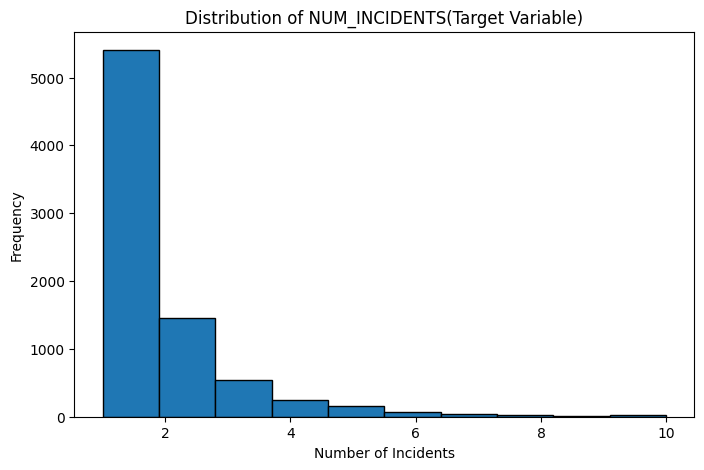

Number of Outliers: 562
   URBANICITY  GATED  MARITAL  AGE  SEX  RACE                ED  INCOME  \
5           2      2        4   48    1     1  High School Grad      18   
6           2      2        4   48    1     1  High School Grad      18   
7           2      2        4   48    1     1  High School Grad      18   
8           2      2        4   48    1     1  High School Grad      18   
9           2      2        4   48    1     1  High School Grad      18   

   REGION  WEAPON  NUM_INCIDENTS  
5       4       2              7  
6       4       2              7  
7       4       2              7  
8       4       2              7  
9       4       2              7  


In [ ]:
# Plot histogram for the target variable NUM_INCIDENTS
plt.figure(figsize=(8, 5))
plt.hist(ncvs_new["NUM_INCIDENTS"], bins=10, edgecolor="black")
plt.xlabel("Number of Incidents")
plt.ylabel("Frequency")
plt.title("Distribution of NUM_INCIDENTS(Target Variable)")
plt.show()

# Identify potential outliers in NUM_INCIDENTS using IQR method
Q1 = ncvs_new["NUM_INCIDENTS"].quantile(0.25)
Q3 = ncvs_new["NUM_INCIDENTS"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier threshold
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers = ncvs_new[(ncvs_new["NUM_INCIDENTS"] < lower_bound) | (ncvs_new["NUM_INCIDENTS"] > upper_bound)]
num_outliers = outliers.shape[0]
print(f"Number of Outliers: {num_outliers}")
print(outliers.head())

# Handle outliers by capping NUM_INCIDENTS at the upper IQR bound
ncvs_new["NUM_INCIDENTS"] = ncvs_new["NUM_INCIDENTS"].apply(lambda x: min(x, upper_bound))

# Encode categorical features using one-hot encoding
ncvs_new_encoded = pd.get_dummies(ncvs_new, columns=categorical_features, drop_first=True)


**Train-test-validation Split**

For this project, I will split the data into training data, test data, and validation data. The proportion for each data will be **70%** for training data, **15%** for testing data and validation data

In [ ]:
# Split dataset into training (70%), validation (15%), and testing (15%)
train_ncvs, temp_ncvs = train_test_split(ncvs_new_encoded, test_size=0.3, random_state=42)
val_ncvs, test_ncvs = train_test_split(temp_ncvs, test_size=0.5, random_state=42)

# Display dataset sizes
dataset_sizes = {
    "Training Set": train_ncvs.shape,
    "Validation Set": val_ncvs.shape,
    "Test Set": test_ncvs.shape,
}
print(dataset_sizes)

{'Training Set': (5577, 40), 'Validation Set': (1195, 40), 'Test Set': (1196, 40)}


### Model Selection and Fine Tuning

In the section below, I will choose the most suitable model from what we covered in class for my data. During the process, I will play around the parameters in each model and evaluate their performances for my data. From the models I tried, I will select the most suitable one and proceed to the next step. Reasons for my selection will be provided.

### Model Approach 1: Linear Regression

The first model I will fit is the linear regression model. Linear regression model is simple and interpretable model that assumes a linear relationship between the target variable `NUM_INCIDENT` and all the features. I will test the performance of the linear regression model first and proceed from there.

In [ ]:
## Import all the packages for model 1 parts
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
#Extract the target variable and features
X_train_reg = train_ncvs.drop(columns="NUM_INCIDENTS")
y_train_reg = train_ncvs["NUM_INCIDENTS"]

#Use validation set to avoid overfitting
X_val_reg = val_ncvs.drop(columns="NUM_INCIDENTS") 
y_val_reg = val_ncvs["NUM_INCIDENTS"]

In [ ]:
#Train and evaluate the linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_reg, y_train_reg)
performance = lin_reg.score(X_train_reg, y_train_reg)
y_pred_reg = lin_reg.predict(X_val_reg)

#Calculate the mean squared error and R2 score
mse_reg = mean_squared_error(y_val_reg, y_pred_reg)
r2_reg = r2_score(y_val_reg, y_pred_reg)
performance, mse_reg, r2_reg = np.round(performance, 3), np.round(mse_reg, 3), np.round(r2_reg, 3)
print(f"Model Performance: {performance}, Mean Squared Error: {mse_reg}, R2 Score: {r2_reg}")

Model Performance: 0.088, Mean Squared Error: 0.602, R2 Score: 0.077


**Evaluation:** Before fine-tuning the linear regression model, the performance of the default model is rather poor. We have the MSE of 0.602 and R-square score of 0.077, which indicates that we only capture 7.7% variance in our target variable. All these measures suggests that this linear model is not capturing the relationship effectively. The reason for this poor performance is likely due to non-linearity in the data. However, before proceed to the next model, I would like to use **L1 and L2 regularization** to fine-tune the model to see if the performance will increase.

**Fine-tuning: L1 Regularization (LASSO) and L2 Regualrization (Ridge)**

For Regularization models I will use is Ridge and LASSO models, I will test the performace of both models on the data with **alpha = 1.0** first, and then try different alpha levels to see if the performance will be better

In [ ]:
# Import the necessary packages for Ridge regression
from sklearn.linear_model import Ridge, Lasso

# Train and evaluate the Ridge regression model
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train_reg, y_train_reg)
performance_R = ridge_reg.score(X_train_reg, y_train_reg)
y_pred_reg = ridge_reg.predict(X_val_reg)
mse_ridge = mean_squared_error(y_val_reg, y_pred_reg) 
r2_ridge = r2_score(y_val_reg, y_pred_reg)
performance_R, mse_ridge, r2_ridge = np.round(performance_R, 3), np.round(mse_ridge, 3), np.round(r2_ridge, 3)
print(f"Model Performance: {performance_R}, Mean Squared Error: {mse_ridge}, R2 Score: {r2_ridge}")

# Train and evaluate the Lasso regression model
lasso_reg = Lasso(alpha=1.0)
lasso_reg.fit(X_train_reg, y_train_reg)
performance_L = lasso_reg.score(X_train_reg, y_train_reg)
y_pred_reg = lasso_reg.predict(X_val_reg)
mse_lasso = mean_squared_error(y_val_reg, y_pred_reg)
r2_lasso = r2_score(y_val_reg, y_pred_reg)
performance_L, mse_lasso, r2_lasso = np.round(performance_L, 3), np.round(mse_lasso, 3), np.round(r2_lasso, 3)
print(f"Model Performance: {performance_L}, Mean Squared Error: {mse_lasso}, R2 Score: {r2_lasso}")

Model Performance: 0.088, Mean Squared Error: 0.602, R2 Score: 0.077
Model Performance: 0.0, Mean Squared Error: 0.652, R2 Score: -0.0


When alpha level is **1.0**, the performance of the Ridge model does not improve significantly and the performance of Lasso model is even worse. I will try different alpha levels to see if the results will be better

In [ ]:
alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]
for alpha in alpha_values:
    ridge_reg = Ridge(alpha=alpha)
    ridge_reg.fit(X_train_reg, y_train_reg)
    performance_R = ridge_reg.score(X_train_reg, y_train_reg)
    y_pred_reg = ridge_reg.predict(X_val_reg)
    mse_ridge = mean_squared_error(y_val_reg, y_pred_reg)
    r2_ridge = r2_score(y_val_reg, y_pred_reg)
    performance_R, mse_ridge, r2_ridge = np.round(performance_R, 3), np.round(mse_ridge, 3), np.round(r2_ridge, 3)
    print(f"Alpha: {alpha}, R_Model Performance: {performance_R}, Mean Squared Error: {mse_ridge}, R2 Score: {r2_ridge}")

    lasso_reg = Lasso(alpha=alpha)
    lasso_reg.fit(X_train_reg, y_train_reg)
    performance_L = lasso_reg.score(X_train_reg, y_train_reg)
    y_pred_reg = lasso_reg.predict(X_val_reg)
    mse_lasso = mean_squared_error(y_val_reg, y_pred_reg)
    r2_lasso = r2_score(y_val_reg, y_pred_reg)
    performance_L, mse_lasso, r2_lasso = np.round(performance_L, 3), np.round(mse_lasso, 3), np.round
    print(f"Alpha: {alpha}, L_Model Performance: {performance_L}, Mean Squared Error: {mse_lasso}, R2 Score: {r2_lasso}")

Alpha: 0.001, R_Model Performance: 0.088, Mean Squared Error: 0.602, R2 Score: 0.077
Alpha: 0.001, L_Model Performance: 0.085, Mean Squared Error: 0.6, R2 Score: <function round at 0x000001F1CE8A5800>
Alpha: 0.01, R_Model Performance: 0.088, Mean Squared Error: 0.602, R2 Score: 0.077
Alpha: 0.01, L_Model Performance: 0.062, Mean Squared Error: 0.614, R2 Score: <function round at 0x000001F1CE8A5800>
Alpha: 0.1, R_Model Performance: 0.088, Mean Squared Error: 0.602, R2 Score: 0.077
Alpha: 0.1, L_Model Performance: 0.012, Mean Squared Error: 0.644, R2 Score: <function round at 0x000001F1CE8A5800>
Alpha: 1, R_Model Performance: 0.088, Mean Squared Error: 0.602, R2 Score: 0.077
Alpha: 1, L_Model Performance: 0.0, Mean Squared Error: 0.652, R2 Score: <function round at 0x000001F1CE8A5800>
Alpha: 10, R_Model Performance: 0.087, Mean Squared Error: 0.601, R2 Score: 0.078
Alpha: 10, L_Model Performance: 0.0, Mean Squared Error: 0.652, R2 Score: <function round at 0x000001F1CE8A5800>
Alpha: 100,

From the results above, we can see that when the **alpha = 0.1** the performance of the Ridge model is the highest(0.088) and when the **alpha = 0.001**, the performance of the Lasso model is the highest(0.085). However, objectively speaking, the performance is way lower than what I need. Therefore, linear regression models might not be suitable for this data.

### Model Approach 2: Tree-based Model
Given the fact that linear regression models is not handling well for the data, it is possible that the relationships between the traget variable and features is not linear. Therefore, the second model I am choosing is **Decision Tree Regressor**. Using decision tree can handle the non-linearity better than linear regression and can capture interactions between categorical and numerical variables.

In [ ]:
#Import package for decision tree
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor(random_state=42, criterion="squared_error")
dt_reg.fit(X_train_reg, y_train_reg)
performance_dt = dt_reg.score(X_train_reg, y_train_reg)
y_pred_dt = dt_reg.predict(X_val_reg)
mse_dt = mean_squared_error(y_val_reg, y_pred_dt)
r2_dt = r2_score(y_val_reg, y_pred_dt)
performance_dt, mse_dt, r2_dt = np.round(performance_dt, 3), np.round(mse_dt, 3), np.round(r2_dt, 3)
print(f"MSE Model Performance: {performance_dt}, Mean Squared Error: {mse_dt}, R2 Score: {r2_dt}")

MSE Model Performance: 0.993, Mean Squared Error: 0.412, R2 Score: 0.368


In [ ]:
#get depth and leaves for the tree
depth = dt_reg.get_depth()
leaves = dt_reg.get_n_leaves()
print(f"Depth: {depth}, Leaves: {leaves}")

Depth: 30, Leaves: 1556


 **Evaluation:** According to the statistics above, the performance for decision tree regressor is much higher than the linear model(0.993) with lower MSE and higher R-square score, which indicates that the decision tree regressor is more suitable for this relationship. The model generate above has a depth of 30 and 1556 leaves, which are generated by default, I will change the parameter in the following sections wot see if the performance can be further improved.

**Fine-tuning: Change parameters and depth:** The model generated above used mean squared error as the criteria and does not set any restrictions to the depth. In the following section, I will explore these changes to find potential improvement

In [ ]:
#Change the criterias
dt_reg_ase = DecisionTreeRegressor(random_state=42, criterion="absolute_error")
dt_reg_ase.fit(X_train_reg, y_train_reg)
performance_dt_ase = dt_reg_ase.score(X_train_reg, y_train_reg)
y_pred_dt = dt_reg_ase.predict(X_val_reg)
mse_dt_ase = mean_squared_error(y_val_reg, y_pred_dt)
r2_dt_ase = r2_score(y_val_reg, y_pred_dt)
performance_dt_ase, mse_dt_ase, r2_dt_ase = np.round(performance_dt_ase, 3), np.round(mse_dt_ase, 3), np.round(r2_dt_ase, 3)
print(f"ASE Model Performance: {performance_dt_ase}, Mean Squared Error: {mse_dt_ase}, R2 Score: {r2_dt_ase}")

dt_reg_poiss = DecisionTreeRegressor(random_state=42, criterion="poisson")
dt_reg_poiss.fit(X_train_reg, y_train_reg)
performance_dt_poiss = dt_reg_poiss.score(X_train_reg, y_train_reg)
y_pred_dt = dt_reg_poiss.predict(X_val_reg)
mse_dt_poiss = mean_squared_error(y_val_reg, y_pred_dt)
r2_dt_poiss = r2_score(y_val_reg, y_pred_dt)
performance_dt_poiss, mse_dt_poiss, r2_dt_poiss = np.round(performance_dt_poiss, 3), np.round(mse_dt_poiss, 3), np.round(r2_dt_poiss, 3)
print(f"Poisson Model Performance: {performance_dt_poiss}, Mean Squared Error: {mse_dt_poiss}, R2 Score: {r2_dt_poiss}")

ASE Model Performance: 0.99, Mean Squared Error: 0.378, R2 Score: 0.421
Poisson Model Performance: 0.993, Mean Squared Error: 0.408, R2 Score: 0.375


According to the statistics above, we can see that when changing the criteria from Mean Squared Error to Absolute Error and Poisson, the general performance of the model does not vary a lot but the MSE and R-square score improved. Comparing to the model using Absolute Error and Poisson, I would prefer the **Absolute Error model**, since the MSE is much lower than the first model and R-squared score is much higher.

In [ ]:
# Evaluate the performance using different max_depth values
max_depth_values = [2, 4, 6, 8, 10, 12, 20, 30, 40]
for depth in max_depth_values:
    dt_reg = DecisionTreeRegressor(random_state=42, criterion="squared_error", max_depth=depth)
    dt_reg.fit(X_train_reg, y_train_reg)
    performance_dt = dt_reg.score(X_train_reg, y_train_reg)
    y_pred_dt = dt_reg.predict(X_val_reg)
    mse_dt = mean_squared_error(y_val_reg, y_pred_dt)
    r2_dt = r2_score(y_val_reg, y_pred_dt)
    performance_dt, mse_dt, r2_dt = np.round(performance_dt, 3), np.round(mse_dt, 3), np.round(r2_dt, 3)
    print(f"Max Depth: {depth}, Model Performance: {performance_dt}, Mean Squared Error: {mse_dt}, R2 Score: {r2_dt}")

Max Depth: 2, Model Performance: 0.06, Mean Squared Error: 0.611, R2 Score: 0.063
Max Depth: 4, Model Performance: 0.1, Mean Squared Error: 0.601, R2 Score: 0.079
Max Depth: 6, Model Performance: 0.182, Mean Squared Error: 0.572, R2 Score: 0.123
Max Depth: 8, Model Performance: 0.283, Mean Squared Error: 0.555, R2 Score: 0.149
Max Depth: 10, Model Performance: 0.382, Mean Squared Error: 0.538, R2 Score: 0.176
Max Depth: 12, Model Performance: 0.49, Mean Squared Error: 0.534, R2 Score: 0.181
Max Depth: 20, Model Performance: 0.9, Mean Squared Error: 0.46, R2 Score: 0.295
Max Depth: 30, Model Performance: 0.993, Mean Squared Error: 0.412, R2 Score: 0.368
Max Depth: 40, Model Performance: 0.993, Mean Squared Error: 0.412, R2 Score: 0.368


When evaluating the model with different depths, it appears that when the depth is too small, the performance is lower and the performance of the model will reach maximum when the depth level is 30. Therefore, `max_depth = 30` seems like a reasonable choice for the model

### Model Approach 3: Random Forest
 The performance for the decision tree regressor model is surprisingly high, which on the one hand, indicate that the model is doing nearly perfect job on the data I have, on the other hand, it may suggest overfitting. Therefore, in the third model, I would use the **Random Forest Regressor**  to solve the overfitting problem and improve the accuracy and generalizability of the model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(random_state=42, n_estimators=100, criterion="squared_error")
rf_reg.fit(X_train_reg, y_train_reg)
performance_rf = rf_reg.score(X_train_reg, y_train_reg)
y_pred_rf = rf_reg.predict(X_val_reg)
mse_rf = mean_squared_error(y_val_reg, y_pred_rf)
r2_rf = r2_score(y_val_reg, y_pred_rf)
performance_rf, mse_rf, r2_rf = np.round(performance_rf, 3), np.round(mse_rf, 3), np.round(r2_rf, 3)
print(f"Rf_Model Performance: {performance_rf}, Mean Squared Error: {mse_rf}, R2 Score: {r2_rf}")

Rf_Model Performance: 0.944, Mean Squared Error: 0.239, R2 Score: 0.634


**Evaluation:** The first random forest model used sqaured error as the criterion, the result is satisfying. In this model, the performance is slight but not significantly lower than the decision tree regressor model, but the MSE and R-square score improves significantly, which in my opinion, suggests the random forest model is the **best fit** so far. In the following sections, I will futher improve the model by changing multiple paramenters.

**Fine Tuning: Change the Criterion and `n_estimators`:** In the following section, I will try to change the criterion of the model and adjust the `n_estimators` to see if the model performance can be improved

In [ ]:
#Change Criterion
rf_reg_mae = RandomForestRegressor(random_state=42, n_estimators=100, criterion="absolute_error")
rf_reg_mae.fit(X_train_reg, y_train_reg)
performance_rf_mae = rf_reg_mae.score(X_train_reg, y_train_reg)
y_pred_rf = rf_reg_mae.predict(X_val_reg)
mse_rf_mae = mean_squared_error(y_val_reg, y_pred_rf)
r2_rf_mae = r2_score(y_val_reg, y_pred_rf)
performance_rf_mae, mse_rf_mae, r2_rf_mae = np.round(performance_rf_mae, 3), np.round(mse_rf_mae, 3), np.round(r2_rf_mae, 3)
print(f"MAE_Model Performance: {performance_rf_mae}, Mean Squared Error: {mse_rf_mae}, R2 Score: {r2_rf_mae}")

rf_reg_poiss = RandomForestRegressor(random_state=42, n_estimators=100, criterion="poisson")
rf_reg_poiss.fit(X_train_reg, y_train_reg)
performance_rf_poiss = rf_reg_poiss.score(X_train_reg, y_train_reg)
y_pred_rf = rf_reg_poiss.predict(X_val_reg)
mse_rf_poiss = mean_squared_error(y_val_reg, y_pred_rf)
r2_rf_poiss = r2_score(y_val_reg, y_pred_rf)
performance_rf_poiss, mse_rf_poiss, r2_rf_poiss = np.round(performance_rf_poiss, 3), np.round(mse_rf_poiss, 3), np.round(r2_rf_poiss, 3)
print(f"Poisson_Model Performance: {performance_rf_poiss}, Mean Squared Error: {mse_rf_poiss}, R2 Score: {r2_rf_poiss}")

MAE_Model Performance: 0.937, Mean Squared Error: 0.242, R2 Score: 0.629
Poisson_Model Performance: 0.945, Mean Squared Error: 0.237, R2 Score: 0.636


Comparing the statistics given above, it is reasonable to conclude that random forest model with the criterion of poisson is performing the best among all the models I chose. The final part of fine-tuning will be adjust `n_estimaors` to see if this can improve the performance

In [ ]:
# eavluate the performance using different n_estimators values
n_estimators_values = [10, 50, 100, 200, 300, 400, 500, 1000]
for n_estimators in n_estimators_values:
    rf_reg = RandomForestRegressor(random_state=42, n_estimators=n_estimators, criterion="poisson")
    rf_reg.fit(X_train_reg, y_train_reg)
    performance_rf = rf_reg.score(X_train_reg, y_train_reg)
    y_pred_rf = rf_reg.predict(X_val_reg)
    mse_rf = mean_squared_error(y_val_reg, y_pred_rf)
    r2_rf = r2_score(y_val_reg, y_pred_rf)
    performance_rf, mse_rf, r2_rf = np.round(performance_rf, 3), np.round(mse_rf, 3), np.round(r2_rf, 3)
    print(f"n_estimators: {n_estimators}, RF_Model Performance: {performance_rf}, Mean Squared Error: {mse_rf}, R2 Score: {r2_rf}")

n_estimators: 10, RF_Model Performance: 0.923, Mean Squared Error: 0.274, R2 Score: 0.581
n_estimators: 50, RF_Model Performance: 0.942, Mean Squared Error: 0.243, R2 Score: 0.628
n_estimators: 100, RF_Model Performance: 0.945, Mean Squared Error: 0.237, R2 Score: 0.636
n_estimators: 200, RF_Model Performance: 0.947, Mean Squared Error: 0.235, R2 Score: 0.64
n_estimators: 300, RF_Model Performance: 0.947, Mean Squared Error: 0.234, R2 Score: 0.642
n_estimators: 400, RF_Model Performance: 0.948, Mean Squared Error: 0.233, R2 Score: 0.643
n_estimators: 500, RF_Model Performance: 0.948, Mean Squared Error: 0.232, R2 Score: 0.645
n_estimators: 1000, RF_Model Performance: 0.948, Mean Squared Error: 0.232, R2 Score: 0.644


The results suggest that when the number of estimators increases, the performance of the model increases at the same time. The performance will stop increasing after the `n_estimators` reaches 500, the computing expenses will also be too high if we increase the `n_estimator` beyond 500. Therefore, in this project, I will use `n_estimators = 500` in the parameter.

According to all the model exploration above, the final model I will implement for the data will be **Random Forest Model**, specifically with `criterion = poisson` and `n_estimators = 500`

In [ ]:
final_model = RandomForestRegressor(random_state=42, n_estimators=500, criterion="poisson")

### Result Analysis:

After determine the final model for the data, I will use the test data to fit the model and finally evaluate the result of the model.

In [ ]:
#fit the model with test data
X_train = train_ncvs.drop(columns="NUM_INCIDENTS")
y_train = train_ncvs["NUM_INCIDENTS"]
X_test = test_ncvs.drop(columns="NUM_INCIDENTS")
y_test = test_ncvs["NUM_INCIDENTS"]

final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)
performance_final = final_model.score(X_train, y_train)
mse_final = mean_squared_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)
performance_final, mse_final, r2_final = np.round(performance_final, 3), np.round(mse_final, 3), np.round(r2_final, 3)
print(f"Final Model Performance: {performance_final}, Mean Squared Error: {mse_final}, R2 Score: {r2_final}")

Final Model Performance: 0.948, Mean Squared Error: 0.208, R2 Score: 0.692


C:\Users\wudon\AppData\Local\Temp\ipykernel_41040\4019473509.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances["Importance"], y=feature_importances["Feature"], palette="viridis")


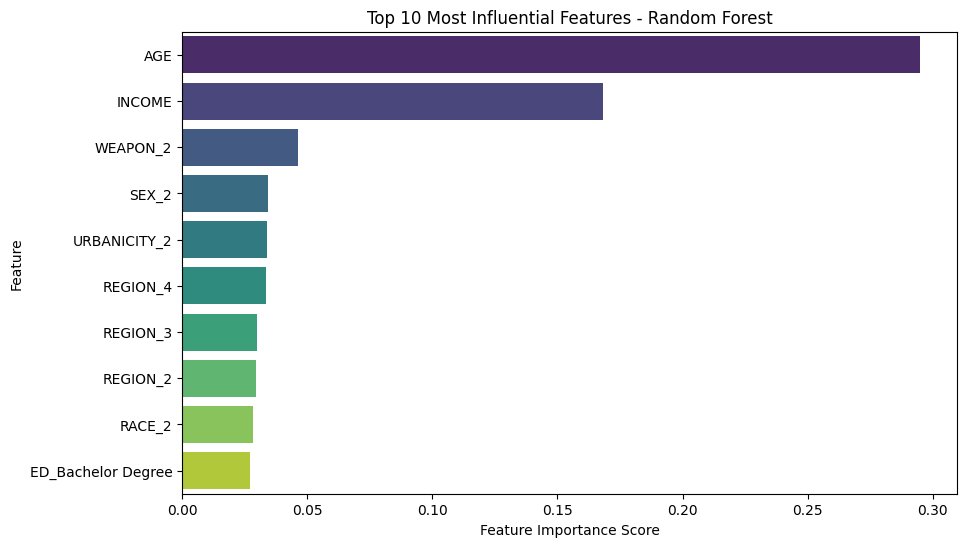

Top 10 Most Important Features:
               Feature  Importance
0                  AGE    0.294917
1               INCOME    0.168252
38            WEAPON_2    0.046466
9                SEX_2    0.034482
2         URBANICITY_2    0.033878
37            REGION_4    0.033456
36            REGION_3    0.030057
35            REGION_2    0.029419
10              RACE_2    0.028538
26  ED_Bachelor Degree    0.027274


In [ ]:
# Get feature importance from the trained Random Forest model
feature_importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": final_model.feature_importances_
}).sort_values(by="Importance", ascending=False).head(10)  # Top 10 features

# Plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances["Importance"], y=feature_importances["Feature"], palette="viridis")
plt.title("Top 10 Most Influential Features - Random Forest")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.show()

# Print the top features
print("Top 10 Most Important Features:")
print(feature_importances)


**Interpretations:** The performance of the final model for the test data is relatively better than the training set. The final performance of the model is 0.948, which is fairly high comparig to all other models I chose. More than that, the mean squared error is relatively low(0.208), indicating the model is predicting the actual values pretty well. Finally the R-square score is 0.692, represents that 69.2% of the variance in the `NUM_INCIDENT` is captured by the model.

As for the importance of the feature, we can see that `AGE` is the most important feature in the model, followed by the `INCOME`. After the first two, the importance dropped significantly but we can generally interpret that whether having a weapon, sex of the individual, urbanicity, region, race, and education all played a role in the relationship

**Conclusions:** Comparing to all other models I chose, this model is doing the best job overall, it shows a strong improvement compared to linear regression model and solve the potential overfitting problems in the decision tree model. However, there is still 30.8% of the variance is still not captured, which suggests there should a room for improvement

### Visualization of the Model: 
Given the final model I choose is the random forest with 500 trees included, it will be unrealistic to visualize all the trees included in the model. Therefore, I will select one tree generated in the process as my final visualization.

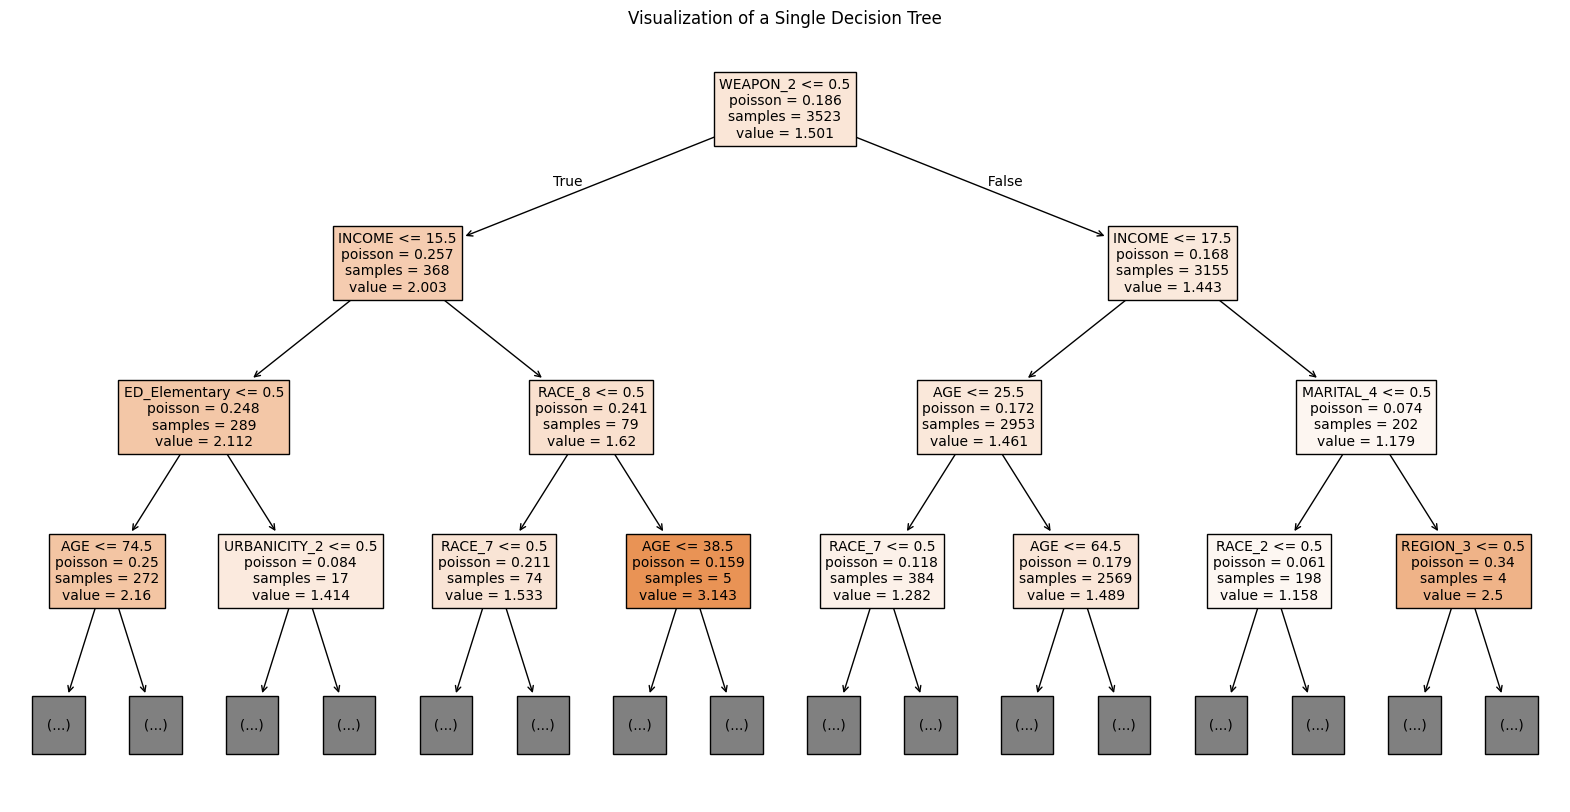

In [ ]:
from sklearn.tree import plot_tree, export_graphviz

single_tree = final_model.estimators_[0]
plt.figure(figsize=(20, 10))
plot_tree(single_tree, filled=True, feature_names=X_train.columns, max_depth=3, fontsize=10)
plt.title("Visualization of a Single Decision Tree")
plt.show()

### Error Analysis:

The final part of this project will be error analysis of the models I chose. In the following section, I will evaluate the errors in the tree models mentioned above and seek for potential improvement. I will also summarize the strength and weakness for each model.

**Comparing the errors across all three models**

In [ ]:
#summary table of the errors in all three models
model_errors = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree Regressor", "Final Random Forest"],
    "MSE": [mse_reg, mse_dt, mse_final],
    "R² Score": [r2_reg, r2_dt, r2_final]
})
print("Error Comparison Across Models:")
print(model_errors)

Error Comparison Across Models:
                     Model    MSE  R² Score
0        Linear Regression  0.602     0.077
1  Decision Tree Regressor  0.412     0.368
2      Final Random Forest  0.208     0.692


**Errors samples for all three models**

In [ ]:
# Ensure y_test matches the shortest prediction array
min_length = min(len(y_test), len(y_pred_reg), len(y_pred_dt), len(y_pred_final))

y_test = y_test[:min_length]
y_pred_lin = y_pred_reg[:min_length]
y_pred_dt = y_pred_dt[:min_length]
y_pred_final = y_pred_final[:min_length]

#Top 5 worst predictions in each model
def get_top_errors(y_true, y_pred, model_name):
    errors = abs(y_true - y_pred)
    error_samples = pd.DataFrame({
        "Actual": y_true,
        "Predicted": y_pred,
        "Error": errors
    }).sort_values(by="Error", ascending=False).head(5)
    error_samples["Model"] = model_name
    return error_samples

error_lin = get_top_errors(y_test, y_pred_reg, "Linear Regression")
error_dt = get_top_errors(y_test, y_pred_dt, "Decision Tree Regressor")
error_rf = get_top_errors(y_test, y_pred_final, "Random Forest Regressor")

top_errors_combined = pd.concat([error_lin, error_dt, error_rf])
print("Top 10 Worst Predictions for Each Model:")
print(top_errors_combined)

Top 10 Worst Predictions for Each Model:
      Actual  Predicted     Error                    Model
1738     3.5   1.494979  2.005021        Linear Regression
156      3.5   1.494979  2.005021        Linear Regression
2590     3.5   1.494979  2.005021        Linear Regression
5327     3.5   1.494979  2.005021        Linear Regression
1402     3.5   1.494979  2.005021        Linear Regression
2590     3.5   1.000000  2.500000  Decision Tree Regressor
2245     1.0   3.500000  2.500000  Decision Tree Regressor
6769     3.5   1.000000  2.500000  Decision Tree Regressor
1917     3.5   1.000000  2.500000  Decision Tree Regressor
694      1.0   3.500000  2.500000  Decision Tree Regressor
809      3.5   1.164000  2.336000  Random Forest Regressor
810      3.5   1.164000  2.336000  Random Forest Regressor
811      3.5   1.164000  2.336000  Random Forest Regressor
1384     1.0   2.739000  1.739000  Random Forest Regressor
1327     3.0   1.434000  1.566000  Random Forest Regressor


### Model Strengths and Weaknesses

**Linear Regression:**

_Strength:_ Linear regression is most suitable for any linear relationships, it is simple to implement and easy to interpret.

_Weakness:_ In this project, linear regression will assume a linear relationship between the target variable and all the features selected, which is not the case in for my dataset. Therefore, the result obtained from linear regression will underfit the data and lead to high error.

**Decision Tree Regressor:**

_Strength:_ Unlike linear regression model, decision tree regressor can capture a more complicated relationship between target variable and features. Unlike random forest, decision tree regressor is easier to visualize and understood, since there will be only one tree for the relationship.

_Weakness:_ The weakness for decision tree regressor is that it is very likely to generate a overfitting model before regularization. Even after regularization, the model will not be generalizable enough for all the testing method. This will result in an underfitting problem



**Random Forest:**

_Strength:_ Random forest model in this project has the lowest error and highest R-square score, which indicates that the model fits the data and predicts the relationship much better than other models. Moreover, due to the nature of random forest, it is more generalizable than otehr models and reduce the overfitting problem.

_Weakness:_ However, the computing expense for random forest is much higher than the other two models and the training process will be rather long if the dataset is too big. Moreover, unlike decision tree regressor, random forest model is harder to interpret because the randome forest model is more like a black box model. Finally, the random forest model is nearly impossible to visualiza, since there will be hundreds of trees in the process.

### Improvements

**Linear Regression:**

* **Feature Engineering:** I can add an interaction term in the model such as(`AGE` * `INCOME`) to improve the model. Moreover, using log transformation can also handle the skewed distributions.
* **Polynomial Regression:** Furthermore, I can use quadratic or cubic terms to model non-linearity, this should partly solve the issue that the linear regression model can only capture the linear relationship.
* **Remove Outlier:** Linear models are sensitive to outliers, identify and remove outliers from the dataset should improve the performance of the model
 


**Decision Tree Regressor:**

* **Pre-prune and post-prune the tree:** To avoid overfitting, I can use post or pre-pruning to resolve the issue. For example, I can set restrictions to `max_depth`, `min_samples_leaf` to prevent deep trees.
* **Feature Selection:** Identify and remove irrelevant features to prevent the tree from memorizing the noise

**Randome Forest Regressor:**

* **Find the Balance:** adjuest the `n_estimator` to improve the speed of computing, without reduce the performance of the model drastically. Increase `min_samples_split` to prevent deep tree.
* **Consider boosting methods:** There are some boosting methods such as Gradient boosting, XGboost for potentially better accuracy. 

### Reference

Bhattacharya, S. (2020). Analysis of the factors affecting violent crime rates in the US. SSRN Electronic Journal.
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3732028

de Nadai, M., Staiano, J., Larcher, R., Sebe, N., & Lepri, B. (2020). Socio-economic, built environment, and mobility conditions associated with crime: A study of multiple cities. arXiv preprint arXiv:2004.05822.
https://arxiv.org/abs/2004.05822

McCord, E. S., & Ratcliffe, J. H. (2018). Factors influencing temporal patterns in crime in a large American city. National Center for Biotechnology Information (NCBI).
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6200217/